In [28]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import numpy as np 
plt.style.use("fivethirtyeight")
%matplotlib inline

In [29]:
train = pd.read_csv("https://raw.githubusercontent.com/benvictoria17/MachineLearning/master/dataset/Health%20Insurance%20Cross%20Sell%20Prediction%20%F0%9F%8F%A0%20%F0%9F%8F%A5/train.csv")

In [30]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [31]:
train.shape

(381109, 12)

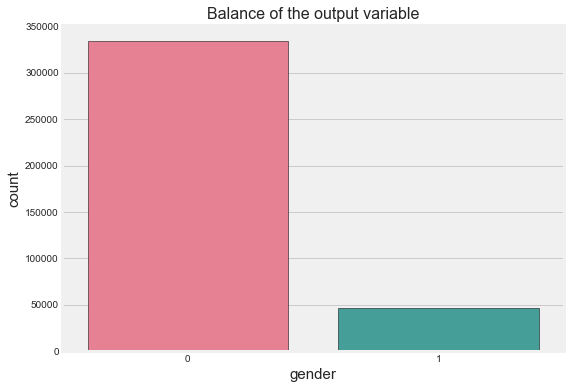

In [32]:
plt.figure(figsize=(8,6))

sns.countplot(x="Response", data = train, palette ="husl" ,edgecolor="black")
plt.ylabel('count', fontsize=15)
plt.xlabel('gender', fontsize=15)
plt.title('Balance of the output variable', fontsize=16)
plt.show()

In [33]:
train['age_range'] = train['Age'].apply(lambda x: 'Adult 1' if 20<x<30 else('Adult 2' if 30 < x < 40 else('Adult 3' if 40<x<65 else 'Elderly')))

In [34]:
train['monthly_premium'] = round(train['Annual_Premium']/12, 2)

In [35]:
train['percentage_total_premium'] = train['Annual_Premium']/train['Annual_Premium'].sum()
df = pd.get_dummies(train['Vehicle_Damage'], prefix='Vehicle_Damage').rename(columns={'vehicle_damage_0':'vehicle_damage_no', 'vehicle_damage_1':'vehicle_damage_yes'})
train  = pd.concat([train, df], axis=1)
train['insured_with_no_damage'] = train['Previously_Insured']*train['Vehicle_Damage_No']
train["not_insured_with_damage"] = train["Previously_Insured"].apply(lambda x: 1 if x == 0 else 0) * train["Vehicle_Damage_Yes"]
train["vehicle_age_<_1_year"] = train["Vehicle_Age"].apply(lambda x: 1 if x=='< 1 Year' else 0)
train["new_damage_no_insurance"] = train["vehicle_age_<_1_year"]*train["not_insured_with_damage"]
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Response,age_range,monthly_premium,percentage_total_premium,Vehicle_Damage_No,Vehicle_Damage_Yes,insured_with_no_damage,not_insured_with_damage,vehicle_age_<_1_year,new_damage_no_insurance
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,...,1,Adult 3,3371.17,0.000003,0,1,0,1,0,0
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,...,0,Elderly,2794.67,0.000003,1,0,0,0,0,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,...,1,Adult 3,3191.17,0.000003,0,1,0,1,0,0
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,...,0,Adult 1,2384.92,0.000002,1,0,1,0,1,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,...,0,Adult 1,2291.33,0.000002,1,0,1,0,1,0


In [36]:
categorical_features = train.select_dtypes(exclude=[np.number])

In [37]:
import scipy.stats

cat_features = categorical_features.columns
train[cat_features] = train[cat_features]


anova = {'feature':[], 'f':[], 'p':[]}
for cat in cat_features:
  group_prices = []
  for group in train[cat].unique():
      group_prices.append(train[train[cat] == group]['Response'].values)
  f, p = scipy.stats.f_oneway(*group_prices)
  anova['feature'].append(cat)
  anova['f'].append(f)
  anova['p'].append(p)
anova = pd.DataFrame(anova)
anova = anova[['feature','f','p']]
anova.sort_values('p', inplace = True)

# p < 0.05
# H0: categorical features don't have any influence in the response (Null hypothesis)

# If p > 0.05 then H0 hypothesis is denied
anova

,feature,f,p
1,Vehicle_Age,9872.132435,0.000000e+00
2,Vehicle_Damage,54742.245365,0.000000e+00
3,age_range,6341.174666,0.000000e+00
0,Gender,1050.913073,3.180742e-230


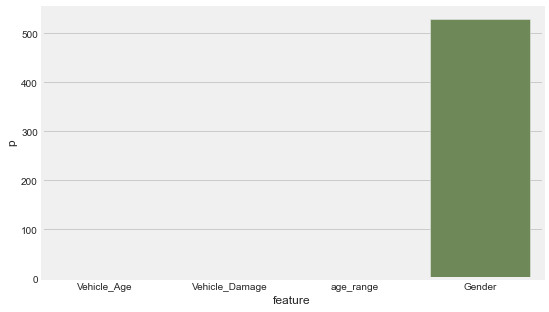

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(anova.feature, np.log(1./anova['p']))
plt.show()

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['Gender'] = le.fit_transform(train['Gender'])
train['Vehicle_Age'] = le.fit_transform(train['Vehicle_Age'])
train['Vehicle_Damage'] = le.fit_transform(train['Vehicle_Damage'])
train['age_range'] = le.fit_transform(train['age_range'])
y = train['Response'].copy()
X = train.drop('Response', axis=1).copy()

In [40]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X,y)
print('The number of lines before oversampling : {}'.format(X.shape[0]))
print('The number of lines after oversampling : {}'.format(X_adasyn.shape[0]))

The number of lines before oversampling : 381109
The number of lines after oversampling : 673035
